In [43]:
from opt.mc_sim import *
import time
from common.variables import *

In [44]:
# sourcingEnv = SourcingEnv(
#         lambda_arrival = 8, # or 10
#         procurement_cost_vec = np.array([3, 1, 2]),
#         supplier_lead_times_vec = np.array([0.8, 0.5, 1.0]),
#         on_times = np.array([1, 1, 2]), 
#         off_times = np.array([0.3, 1, 0.2]))

# Dual Sourcing
sourcingEnv = SourcingEnv(
        lambda_arrival = LAMBDA, # or 10
        procurement_cost_vec = np.array([3, 1]),
        supplier_lead_times_vec = np.array([0.8, 0.5]),
        on_times = np.array([1, 1]), 
        off_times = np.array([0.3, 1]))

s_custom = MState(stock_level = 50, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

mc_avg_costs = mc_with_ss_policy(sourcingEnv, start_state = s_custom)

# print(mc_avg_costs)

time per 100 iter: 0.013106822967529297


In [45]:
print(s_custom)

Stock: 50, n backorders: [0 0], supplier status (on/off): [1 1]


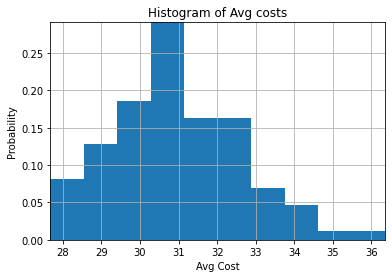

In [46]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 0.3
# n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [47]:
print(np.mean(np.array(mc_avg_costs)))

30.950101010101005


In [48]:
np.std(np.array(mc_avg_costs))

1.6414046060329095

In [49]:
print(sourcingEnv.reset())

Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]


In [51]:
repr(str(sourcingEnv.reset()))

"'Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]'"